In [13]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
from presentation.pipelines.steps.model_design import build_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
params = {
    'num_layers':2,
    'head_dim':64,
    'num_heads':4,
    'window_size':10,
    'mixer':128,
    'pe_base':1000,
    'pe_dim':256,
    'pe_exp':2,
    'dropout':0.,
    'use_leak':False,
    'm_alpha':1,
    'loss_format':'rmse',
    'correct_loss':False,
    'temperature':0.,
    'mask_format':'QK',
}

zero_params = {**params, **{'arch': 'zero'}}
base_params = {**params, **{'arch': 'base'}}
base_params['pe_base'] = 10000

In [16]:
astromer_0 = build_model(zero_params)
astromer_1 = build_model(base_params)

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: QK
[INFO] Using PE with c: 2


In [17]:
astromer_0.load_weights('./presentation/results/paper/pretraining/weights')

In [18]:
astromer_1.load_weights('./presentation/results/paper/pretraining/weights')

In [19]:
astromer_0.input

{'input': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'input')>,
 'mask_in': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'mask')>,
 'times': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'times')>}

In [20]:
astromer_1.input

{'input': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'input')>,
 'times': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'times')>,
 'mask_in': <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'mask_in')>}

In [21]:
input_test = {'input': tf.random.uniform([2, 10, 1], minval=0., maxval=1., dtype=tf.float32),
              'times': tf.random.uniform([2, 10, 1], minval=0., maxval=1., dtype=tf.float32),
              'mask_in': tf.random.uniform([2, 10, 1], minval=0, maxval=1, dtype=tf.int32)}
input_test['mask_in'] = tf.cast(input_test['mask_in'], tf.float32)

In [22]:
embedding_0 = astromer_0.get_layer('encoder')(input_test)
embedding_1 = astromer_1.get_layer('encoder')(input_test)

[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Using PE with c: 2


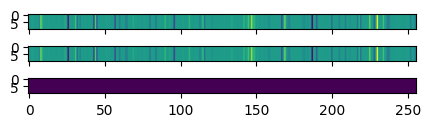

In [23]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(5, 5), gridspec_kw={'hspace':-0.9})
axes[0].imshow(embedding_0[0])
axes[1].imshow(embedding_1[0])
axes[2].imshow(embedding_0[0]-embedding_1[0])
plt.show()